In [20]:
import os
import pandas as pd
import numpy as np
import mplfinance as mpf

from binance.client import Client
from binance import Client, ThreadedWebsocketManager, ThreadedDepthCacheManager
API_KEY = os.environ.get('BINANCE_API_KEY')
API_SECRET = os.environ.get('BINANCE_API_SECRET')

client = Client(API_KEY, API_SECRET)

In [4]:
# tickers = client.get_all_tickers()
# ticker_dataframe = pd.DataFrame(tickers)
# ticker_dataframe.head()

In [5]:
# Getting depth data
# depth = client.get_order_book(symbol='ETHUSDT')
# depth_dataframe = pd.DataFrame(depth['asks'])
# depth_dataframe.columns = ['Price', 'Volume']
# depth_dataframe.head()

In [93]:
# Getting historical data
historical_data = client.get_historical_klines('ETHUSDT', Client.KLINE_INTERVAL_12HOUR, '1 Jan 2022', '20 May 2022')
hist_df = pd.DataFrame(historical_data)
hist_df.columns = ['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close Time', 'Quote Asset Volume', 
                    'Number of Trades', 'TB Base Volume', 'TB Quote Volume', 'Ignore']
hist_df['Open Time'] = pd.to_datetime(hist_df['Open Time']/1000, unit='s')
hist_df['Close Time'] = pd.to_datetime(hist_df['Close Time']/1000, unit='s')
numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Quote Asset Volume', 'TB Base Volume', 'TB Quote Volume']
hist_df[numeric_columns] = hist_df[numeric_columns].apply(pd.to_numeric, axis=1)     
# hist_df.set_index('Open Time', inplace=True)
# hist_df.info()
hist_df.head()
# hist_df['Volatility'].head()

,Open Time,Open,High,Low,Close,Volume,Close Time,Quote Asset Volume,Number of Trades,TB Base Volume,TB Quote Volume,Ignore
0,2022-01-01 00:00:00,3676.22,3765.27,3673.46,3693.37,77571.9043,2022-01-01 11:59:59.999000064,2.884519e+08,210192,38736.6113,1.440399e+08,0
1,2022-01-01 12:00:00,3693.38,3776.45,3691.88,3765.54,76571.9925,2022-01-01 23:59:59.999000064,2.862665e+08,198474,38201.3685,1.428155e+08,0
2,2022-01-02 00:00:00,3765.54,3771.00,3717.30,3744.01,54526.2411,2022-01-02 11:59:59.999000064,2.043379e+08,168656,27210.0011,1.019637e+08,0
3,2022-01-02 12:00:00,3744.06,3857.44,3730.33,3828.27,100265.1852,2022-01-02 23:59:59.999000064,3.810370e+08,281954,53960.5042,2.050929e+08,0
4,2022-01-03 00:00:00,3828.11,3845.00,3775.70,3834.61,90464.9796,2022-01-03 11:59:59.999000064,3.445378e+08,233639,46064.3268,1.754687e+08,0


In [102]:
from ta.utils import dropna
from ta.volatility import BollingerBands
from ta.trend import EMAIndicator

# Calculate MA
hist_df['MA 33'] = hist_df['Close'].rolling(33).mean()
hist_df['MA 55'] = hist_df['Close'].rolling(55).mean()
previous_33 = hist_df['MA 33'].shift(1)
previous_55 = hist_df['MA 55'].shift(1)
crossing_down = ((hist_df['MA 33'] <= hist_df['MA 55']) & (previous_33 >= previous_55))
crossing_up = ((hist_df['MA 33'] >= hist_df['MA 55']) & (previous_33 <= previous_55))
crossing_down_dates = hist_df.loc[crossing_down, 'Close Time']
crossing_up_dates = hist_df.loc[crossing_up, 'Close Time']

# Crossover Signals
hist_df['Short Signals'] = crossing_down_dates
hist_df['Long Signals'] = crossing_up_dates
hist_df['Long Signals'] = hist_df['Long Signals'].astype('int').where(hist_df['Long Signals'].notnull(),np.nan)
hist_df['Short Signals'] = hist_df['Short Signals'].astype('int').where(hist_df['Short Signals'].notnull(),np.nan)
hist_df['Long Price'] = hist_df['Low'].where(hist_df['Long Signals'] > 0)
hist_df['Short Price'] = hist_df['High'].where(hist_df['Short Signals'] > 0)

# MACD 
exp12 = hist_df['Close'].ewm(span=12, adjust=False).mean()
exp26 = hist_df['Close'].ewm(span=26, adjust=False).mean()
macd = exp12 - exp26
signal  = macd.ewm(span=9, adjust=False).mean()
histogram = macd - signal

#Calculate EMA
indicator_ema_1 = EMAIndicator(close=hist_df['Close'], window=8)
indicator_ema_2 = EMAIndicator(close=hist_df['Close'], window=21)
hist_df['EMA 8'] = indicator_ema_1.ema_indicator()
hist_df['EMA 21'] = indicator_ema_2.ema_indicator()

# previous_33 = hist_df['EMA 8'].shift(1)
# previous_55 = hist_df['EMA 20'].shift(1)

# crossing_down = ((hist_df['EMA 8'] <= hist_df['EMA 20']) & (previous_33 >= previous_55))
# crossing_up = ((hist_df['EMA 8'] >= hist_df['EMA 20']) & (previous_33 <= previous_55))
# crossing_down_dates = hist_df.loc[crossing_down, 'Close Time']
# crossing_up_dates = hist_df.loc[crossing_up, 'Close Time']

# # Crossover Signals
# hist_df['Short Signals'] = crossing_down_dates
# hist_df['Long Signals'] = crossing_up_dates
# hist_df['Long Signals'] = hist_df['Long Signals'].astype('int').where(hist_df['Long Signals'].notnull(),np.nan)
# hist_df['Short Signals'] = hist_df['Short Signals'].astype('int').where(hist_df['Short Signals'].notnull(),np.nan)


# Initialize Bollinger Bands Indicator
indicator_bb = BollingerBands(close=hist_df["Close"], window=20, window_dev=2)

# Add Bollinger Bands features
hist_df['PercentB'] = indicator_bb.bollinger_pband()
hist_df['UpperB'] = indicator_bb.bollinger_hband()
hist_df['LowerB'] = indicator_bb.bollinger_lband()

# Add Bollinger Band high indicator
hist_df['BB High'] = indicator_bb.bollinger_hband_indicator()
# Add Bollinger Band low indicator
hist_df['BB Low'] = indicator_bb.bollinger_lband_indicator()
# hist_df['Long Signals'].tail()
# long_df = hist_df[(hist_df['Long Price'] > 0)]
# # long_df['Close']
# hist_df['Long Price'].count()
# Calculating BB Band
def percentB_belowzero(percentB,price):
    import numpy as np
    signal   = []
    previous = -1.0
    for date,value in percentB.iteritems():
        if value < 0 and previous >= 0:
            signal.append(price[date]*0.99)
        else:
            signal.append(np.nan)
        previous = value
    return signal

bb_low = percentB_belowzero(hist_df['PercentB'], hist_df['Close'])

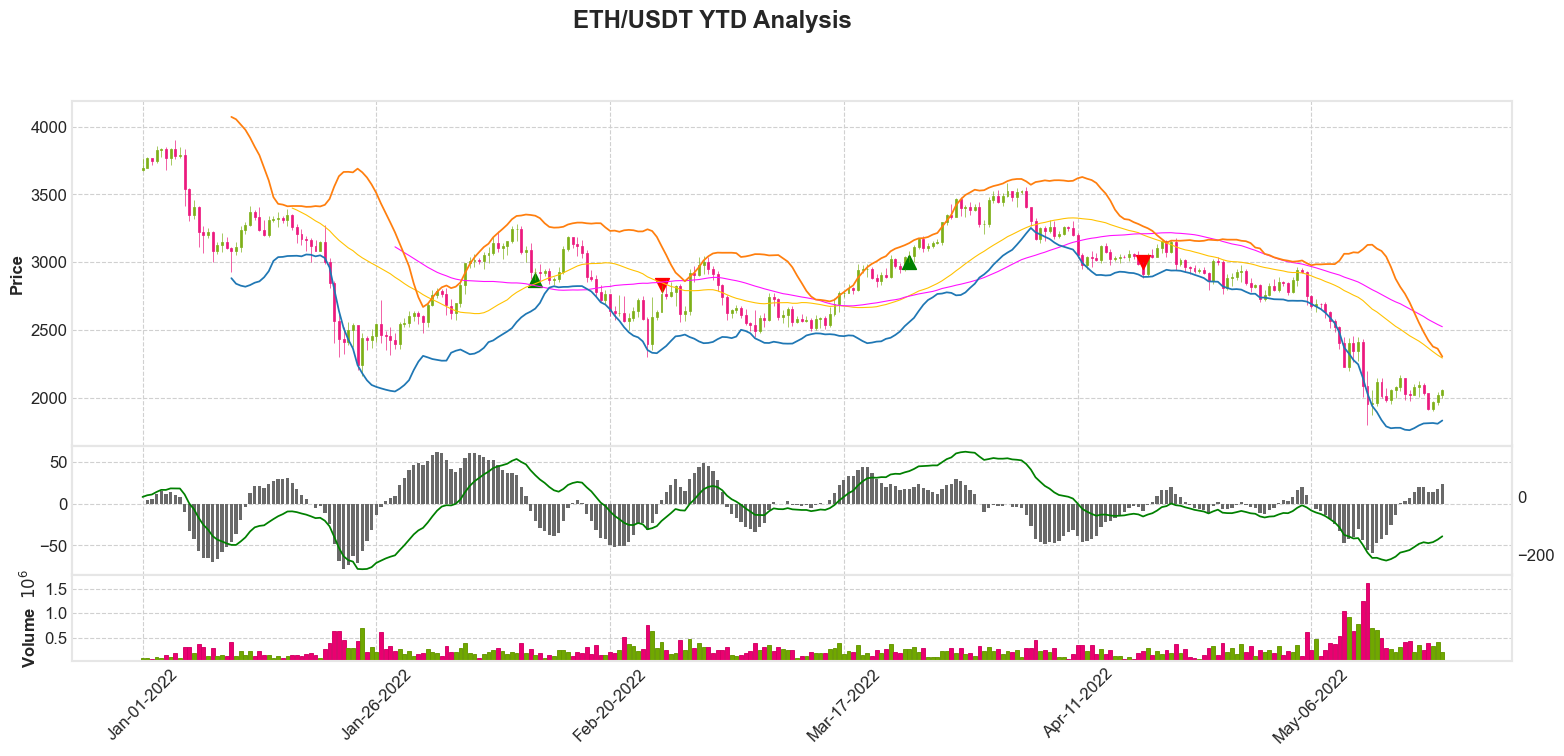

In [107]:

# apd = mpf.make_addplot(bb_signal,type='scatter')
# Plot
signals = [
        # mpf.make_addplot(bb_low, type='scatter', markersize=200, marker='^'),
        # mpf.make_addplot(hist_df['BB Low'], type='scatter', markersize=200, marker='^'),
        mpf.make_addplot(hist_df['Long Price'] , type='scatter', markersize=100, color='g', marker='^'),
        mpf.make_addplot(hist_df['Short Price'] , type='scatter', markersize=100, color='r', marker='v'),

        # mpf.make_addplot(hist_df['Long Signals'], type='bar', color='g', y_on_right=False),
        # mpf.make_addplot(hist_df['Short Signals'], type='bar', color='r', y_on_right=False),
        # mpf.make_addplot(exp12,color='lime'),
        # mpf.make_addplot(exp26,color='c'),
        # mpf.make_addplot(signal, panel=1, color='red', secondary_y=True),
        mpf.make_addplot(histogram, type='bar', width=0.7, panel=1,
                         color='dimgray', alpha=1, secondary_y=False),
        mpf.make_addplot(macd, panel=1, color='green', secondary_y=True),
        mpf.make_addplot(hist_df['LowerB']),
        mpf.make_addplot(hist_df['UpperB']),
        # mpf.make_addplot(hist_df['EMA 8']),
        # mpf.make_addplot(hist_df['EMA 21'])        
]
# style  = mpf.make_mpf_style(base_mpl_style='yahoo')
# mpf.plot(tdf,addplot=apd)
mpf.plot(hist_df.set_index('Close Time'),
        type='candle', 
        style='binance', 
        volume=True,
        title='ETH/USDT YTD Analysis',
        figsize=[20,8], 
        # figscale=1.2,
        mav=(33,55),
        # tight_layout=True,
        datetime_format='%b-%d-%Y',
        volume_panel=2,
        panel_ratios=(8,3,2),
        addplot=signals
        )

In [106]:
df_signals = hist_df.loc[(hist_df['Long Signals'] > 0) | (hist_df['Short Signals'] > 0)]
# df_signals.style.format({'Close Time': lambda t: t.strftime("%m/%d/%Y")})
# pd.to_datetime(hist_df['Open Time']/1000, unit='s')
pd.options.mode.chained_assignment = None
import math
df_signals['Signals'] = ['Long' if not math.isnan(s) else 'Short' for s in df_signals['Long Signals']]
# df_signals['Signals'] = ['Short' if s != np.nan else '' for s in df_signals['Short Signals']]

df_signals["Time"] = pd.to_datetime(df_signals["Close Time"]).dt.strftime('%b %d %Y')
result = df_signals[['Time','Open','High','Low','Close','Number of Trades', 'Signals']]
# result.reset_index(drop=True)
# df_signals
result.reset_index(drop=True)


,Time,Open,High,Low,Close,Number of Trades,Signals
0,Feb 12 2022,2927.54,2959.65,2871.61,2931.09,265643,Long
1,Feb 25 2022,2632.89,2834.97,2632.65,2768.49,640587,Short
2,Mar 24 2022,3035.99,3081.07,2999.11,3048.58,410468,Long
3,Apr 18 2022,2988.07,3002.39,2883.22,2911.85,312413,Short
